In [20]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [21]:
batch_size = 128
seed = 1
log_interval = 100

torch.manual_seed(seed)
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=False, **kwargs)

latent_space_dim = 2

In [22]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_space_dim)
        self.fc22 = nn.Linear(400, latent_space_dim)
        self.fc3 = nn.Linear(latent_space_dim, 400)
        self.fc41 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc41(h3))

    def forward(self, x):
        mu_z, logvar_z = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu_z, logvar_z)
        mu_x = self.decode(z)
        return mu_x, mu_z, logvar_z

In [23]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
# Loss function - note that since we use Gaussian VAE with unit variance -ln(p(x|z)) is just L^2 loss
def loss_function(x, mu_x, mu_z, logvar_z):
    lnP = torch.nn.functional.mse_loss(x.view(-1, 784), mu_x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
    return lnP + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        mu_x, mu_z, logvar_z = model(data)
        loss = loss_function(data, mu_x, mu_z, logvar_z)
        loss.backward()
        train_loss += loss.detach().cpu()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss.item() / len(train_loader.dataset)

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            mu_x, mu_z, logvar_z = model(data)
            test_loss += loss_function(data, mu_x, mu_z, logvar_z)
            if i == 0:
                n = min(data.size(0), 8)
                recon_batch = mu_x # when we sample we just use the maximum likelihood x
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                         
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/60000 (0%)]	Loss: 185.763931
Train Epoch: 1 [12800/60000 (21%)]	Loss: 48.824348
Train Epoch: 1 [25600/60000 (43%)]	Loss: 47.561737
Train Epoch: 1 [38400/60000 (64%)]	Loss: 44.146664
Train Epoch: 1 [51200/60000 (85%)]	Loss: 46.616165
====> Epoch: 1 Average loss: 49.0182
====> Test set loss: 43.1747
Train Epoch: 2 [0/60000 (0%)]	Loss: 43.721836
Train Epoch: 2 [12800/60000 (21%)]	Loss: 41.913559
Train Epoch: 2 [25600/60000 (43%)]	Loss: 41.874813
Train Epoch: 2 [38400/60000 (64%)]	Loss: 41.137733
Train Epoch: 2 [51200/60000 (85%)]	Loss: 42.831104
====> Epoch: 2 Average loss: 42.2298
====> Test set loss: 41.2653
Train Epoch: 3 [0/60000 (0%)]	Loss: 42.929001
Train Epoch: 3 [12800/60000 (21%)]	Loss: 40.777317
Train Epoch: 3 [25600/60000 (43%)]	Loss: 40.330795
Train Epoch: 3 [38400/60000 (64%)]	Loss: 39.542446
Train Epoch: 3 [51200/60000 (85%)]	Loss: 42.730652
====> Epoch: 3 Average loss: 40.9172
====> Test set loss: 40.4203
Train Epoch: 4 [0/60000 (0%)]	Loss: 40.824810
Train

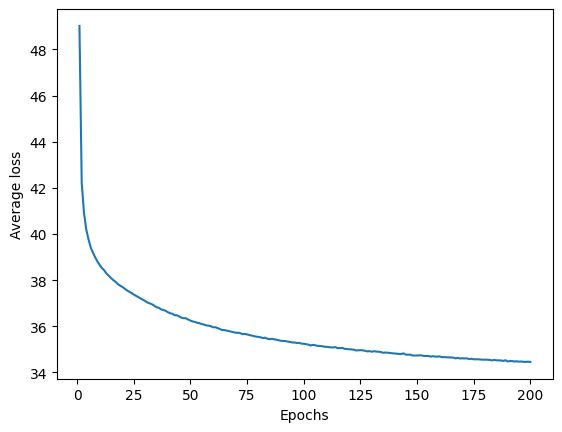

<Figure size 640x480 with 0 Axes>

In [25]:
epochs = 200
loss_series = []
for epoch in range(1, epochs + 1):
    avg_loss = train(epoch)
    loss_series.append(avg_loss)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, latent_space_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')

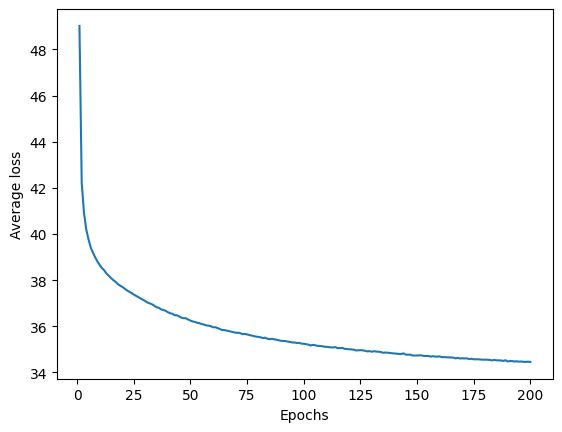

In [28]:
plt.plot(range(1,epochs +1), loss_series)
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.savefig(R"simple_VAE_loss.png")

In [26]:
torch.save(model.state_dict(), f"simple_VAE.pth")

In [31]:
import numpy as np

def generate_samples(model, batch_size):
    mu = torch.zeros([batch_size, latent_space_dim], device=device)
    logvar = torch.zeros([batch_size, latent_space_dim], device=device)
    z = model.reparameterize(mu, logvar)
    img = model.decode(z)
    img = img.view(size = (batch_size, 1, 28, 28,))
    return img

def generate_many_samples(model, count, batch_size):
    n_batches = int(count / batch_size) 
    result = torch.zeros(size=(0,1,28,28))
    for i in range(n_batches):
        samples = generate_samples(model, batch_size).detach().cpu()
        result = torch.cat([result, samples], dim = 0)
    return result

many_samples = generate_many_samples(model, 10000, batch_size=100)
np.save(R"FC_VAE_samples.npy", many_samples.squeeze().numpy())

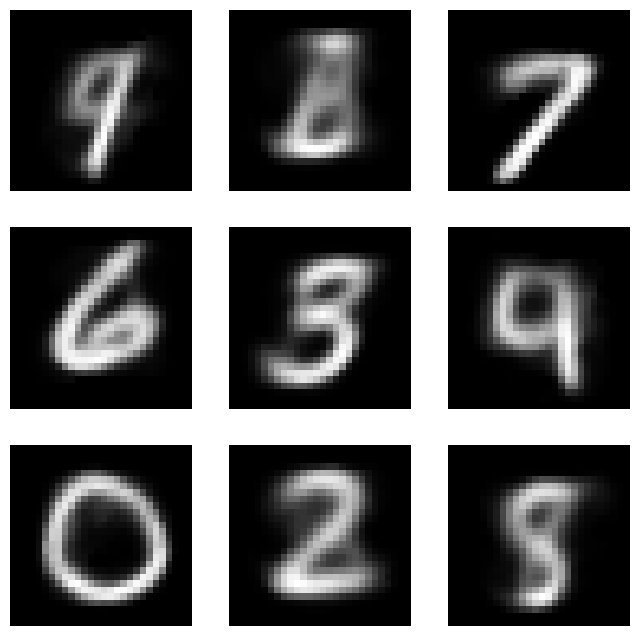

In [32]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img = many_samples[i]
    img=img.to('cpu').detach().numpy()
    img = img.reshape((1,1,28,28))

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()